In [2]:
import numpy as np
import tqdm 
import scipy.io
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import copy 
import json

from pathlib import Path
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA, SparsePCA
from pingouin import ancova
from scipy import stats
from statsmodels.stats import multitest
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# maybe not used
from statsmodels.multivariate import manova
from matplotlib import colors

# made a hard link to the dataset here
path_aMats = '../A_mats/' 
path_corr = '../corrs/' 
path_subInfo = '../SRPBS_OPEN/participants.tsv'

In [3]:
pwd

'C:\\Users\\sarah\\Documents\\university\\NSC\\0_SS21\\TNM\\project\\translational-neuromodelling-mdd\\Dataset Analysis'

# participants info 

In [4]:
# get outliers
with open('../Dataset Analysis/dataset_inliers.txt','r') as f:
    ids_inliers_all = np.array(json.loads(f.read()))

In [5]:
# get mdd and hc subInfo 
parti = pd.read_table(path_subInfo)

In [6]:
def participant_id_to_number(participant_id: str) -> int:
    return int(participant_id.split('-')[1])

def extract_participants_id(participants: pd.DataFrame, id: int) -> pd.DataFrame:
    return participants[[participant_id_to_number(name) == id for name in participants.participant_id.to_numpy()]]

In [7]:
participants = pd.DataFrame()
for idx in ids_inliers_all:
    tmp = extract_participants_id(parti, idx)
    participants = participants.append(tmp, ignore_index=True)
    
participants

,participant_id,site,protocol,diag,age,sex,hand,sup
0,sub-0001,SWA,1,0,23,1,1.0,1
1,sub-0002,SWA,1,0,23,2,1.0,1
2,sub-0003,SWA,1,0,26,1,1.0,1
3,sub-0004,SWA,1,0,23,1,1.0,1
4,sub-0005,SWA,1,0,24,1,1.0,1
...,...,...,...,...,...,...,...,...
989,sub-1382,CIN,14,0,40,1,1.0,8
990,sub-1383,CIN,14,0,31,2,1.0,8
991,sub-1384,CIN,14,0,37,1,1.0,8
992,sub-1385,CIN,14,0,20,2,1.0,8


### create numerical sites

In [8]:
for idx, site_name in enumerate(np.unique((participants.site))):
    participants.loc[participants.site == site_name, 'site_num'] = idx

### create 4 categorical age classes 

In [9]:
np.unique(participants['age'])

array([18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 77, 78, 79, 80], dtype=int64)

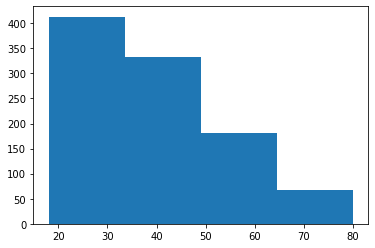

In [10]:
hist = plt.hist(participants['age'], bins=4)
plt.show()

In [11]:
participants.loc[participants.age <= 32, 'age_cat'] = 0
participants.loc[(participants.age > 32) & (participants.age <= 48), 'age_cat'] = 1
participants.loc[(participants.age > 48) & (participants.age <= 64), 'age_cat'] = 2
participants.loc[(participants.age > 64) & (participants.age <= 80), 'age_cat'] = 3

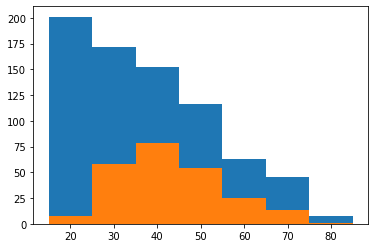

In [12]:
hist = plt.hist(participants[participants['diag'] == 0]['age'], np.arange(15, 95, 10))
hist = plt.hist(participants[participants['diag'] == 2]['age'], np.arange(15, 95, 10))
plt.show()

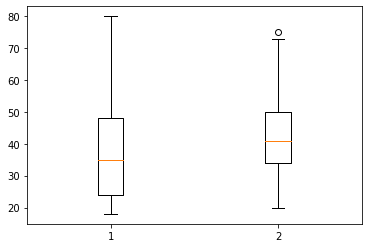

In [13]:
plt.boxplot(participants[participants['diag'] == 2]['age'], positions=[2])
plt.boxplot(participants[participants['diag'] == 0]['age'])
plt.show()

<br/><br/><br/><br/>

# A_mats

In [14]:
def read_A_matrix(subject: int) -> np.ndarray:
    return scipy.io.loadmat(f'{path_aMats}/dcm_A_{subject:04d}.mat')['A']

In [15]:
all_mats = np.zeros((len(ids_inliers_all), 377, 377))

for i, idx in enumerate(ids_inliers_all):
    a_mat = read_A_matrix(idx)
    all_mats[i, :, :] = a_mat
    
all_mats.shape

(994, 377, 377)

In [16]:
all_mats_2d = all_mats.reshape(all_mats.shape[0], all_mats.shape[1]*all_mats.shape[1])
all_mats_2d.shape

(994, 142129)

In [17]:
mats_df = pd.DataFrame(data = all_mats_2d)
participants.reset_index(drop=True, inplace=True)
df_mats_2d = pd.concat([mats_df, participants], axis=1)
df_mats_2d.shape

(994, 142139)

In [18]:
labels_3d = np.array(df_mats_2d['diag'])
labels_3d.shape

(994,)

### Plot the average connectivity matrix of the two groups 

In [19]:
def reorder_regions(mat):
    new_mat = copy.deepcopy(mat)
    
    # flip the complete right hand side from left-to-right
    new_mat[:, 189:] = np.fliplr(mat[:, 189:])
    
    # flip the complete bottom half from up-to-down
    new_mat[189:, :] = np.flipud(new_mat[189:, :])
    
    return new_mat

In [21]:
controls_mats_avg = np.mean(all_mats[labels_3d == 0], 0)
patients_mats_avg = np.mean(all_mats[labels_3d == 2], 0)
all_mats_avg = np.mean(all_mats_2d, 0)

(142129,)

# TODO: label axes + save figure + agree on boundaries

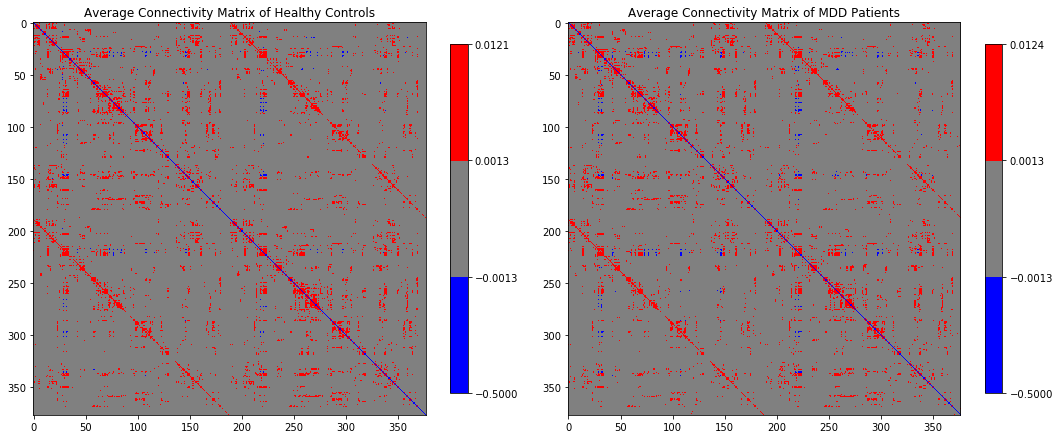

In [25]:
# make a color map of fixed colors
cmap = colors.ListedColormap(['blue', 'gray', 'red'])
bounds_c = [np.min(controls_mats_avg),(-0.0025/2),(0.0025/2),np.max(controls_mats_avg)]
bounds_p = [np.min(patients_mats_avg),(-0.0025/2),(0.0025/2),np.max(patients_mats_avg)]
norm_c = colors.BoundaryNorm(bounds_c, cmap.N)
norm_p = colors.BoundaryNorm(bounds_p, cmap.N)

fig, ax = plt.subplots(1, 2, figsize=(15, 10))

ax[0].set_title('Average Connectivity Matrix of Healthy Controls')
img1 = ax[0].imshow(reorder_regions(controls_mats_avg), interpolation='nearest', cmap=cmap, norm=norm_c)
fig.colorbar(img1, ax=ax[0], cmap=cmap, norm=norm_c, boundaries=bounds_c, ticks=bounds_c, shrink=0.5)


ax[1].set_title('Average Connectivity Matrix of MDD Patients')
img2 = ax[1].imshow(reorder_regions(patients_mats_avg), interpolation='nearest', cmap=cmap, norm=norm_p)
fig.colorbar(img2, ax=ax[1], cmap=cmap, norm=norm_p, boundaries=bounds_p, ticks=bounds_p, shrink=0.5)

plt.tight_layout()
plt.show() 

<br/><br/><br/><br/>

# Correlations

In [26]:
def read_correlation(subject: int) -> np.ndarray:
    return np.nan_to_num(scipy.io.loadmat(f'{path_corr}/correlation_components_{subject:04d}.mat')['corr_components'].reshape(1,-1))

In [27]:
all_cors = np.zeros((len(ids_inliers_all), 70876))
NaN_subs = []

for i, idx in enumerate(ids_inliers_all):
    corr = read_correlation(idx)
    if np.any(np.isnan(corr)):
        NaN_subs.append(name)
    all_cors[i] = np.squeeze(corr)
    
all_cors = np.nan_to_num(all_cors)
all_cors.shape
print(f' {len(NaN_subs)} subjects have NaNs in their correlation matrix')

 0 subjects have NaNs in their correlation matrix


In [28]:
def flatt2mat(vec, dim):
    full_mat = np.zeros((dim, dim))
    triangle_indi = np.tril_indices(dim, -1)
    triangle_indi_order = np.argsort(triangle_indi[1], kind='stable')
    triangle_indi = tuple(np.array(triangle_indi)[:, triangle_indi_order])
    
    full_mat[triangle_indi] = vec.flatten()
    return full_mat

In [29]:
# dinstinguish between mdd and hc 
controls_cors = all_cors[labels_3d == 0]
patients_cors = all_cors[labels_3d == 2]

# compute averages 
controls_avg_cors = np.mean(controls_cors, 0)
patients_avg_cors = np.mean(patients_cors, 0)

# get full mat for averages to display them 
controls_avg_cors_3d = flatt2mat(controls_avg_cors, 377)
patients_avg_cors_3d = flatt2mat(patients_avg_cors, 377)

### Data frames corrs

In [30]:
corrs_df = pd.DataFrame(data = all_cors)
participants.reset_index(drop=True, inplace=True)
df_corrs = pd.concat([corrs_df, participants], axis=1)
df_corrs.shape

(994, 70886)

### Plot average correlation of two groups

In [31]:
def mirrow_triangle(full_tril):
    # flip lower triangle to upper triangle 
    full_triu = np.flipud(np.fliplr(full_tril))
    
    # combine triangles
    mirrow = full_tril + full_triu
    
    return mirrow

# TODO add axes labels + save figure + boundaries

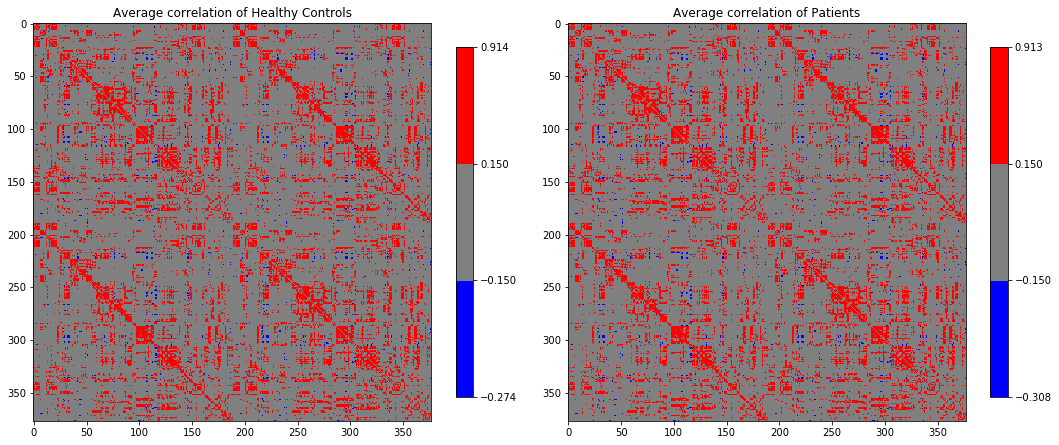

In [32]:
# make a color map of fixed colors
cmap = colors.ListedColormap(['blue', 'gray', 'red'])
bounds_c = [np.min(controls_avg_cors_3d),-0.15, 0.15, np.max(controls_avg_cors_3d)]
bounds_p = [np.min(patients_avg_cors_3d),-0.15, 0.15, np.max(patients_avg_cors_3d)]
norm_c = colors.BoundaryNorm(bounds_c, cmap.N)
norm_p = colors.BoundaryNorm(bounds_p, cmap.N)

fig, ax = plt.subplots(1, 2, figsize=(15, 10))

ax[0].set_title('Average correlation of Healthy Controls')
img1 = ax[0].imshow(reorder_regions(mirrow_triangle(controls_avg_cors_3d)), interpolation='nearest', cmap=cmap, norm=norm_c)
fig.colorbar(img1, ax=ax[0], cmap=cmap, norm=norm_c, boundaries=bounds_c, shrink=0.5)

ax[1].set_title('Average correlation of Patients')
img2 = ax[1].imshow(reorder_regions(mirrow_triangle(controls_avg_cors_3d)), interpolation='nearest', cmap=cmap, norm=norm_p)
fig.colorbar(img2, ax=ax[1], cmap=cmap, norm=norm_p, boundaries=bounds_p, shrink=0.5)

plt.tight_layout()
plt.show() 

<br/><br/><br/><br/>

# Summary Stats

### distribution, descriptive statistics

In [33]:
sns.set_theme(color_codes=True)

### Correlations

In [36]:
# average correlations
df_controls_cors_avg = pd.DataFrame({'avg_correlation': controls_avg_cors, 'diagnosis': 'hc'})
df_patients_cors_avg = pd.DataFrame({'avg_correlation': patients_avg_cors, 'diagnosis': 'mdd'})
df_corrs_avg = df_patients_cors_avg.append(df_controls_cors_avg)

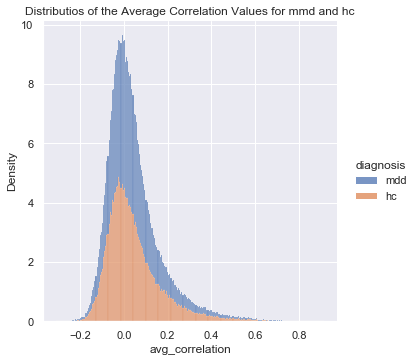

In [37]:
# look at distribution of correlations for the average of the two groups 
sns.displot(data=df_corrs_avg, x='avg_correlation', hue='diagnosis', multiple='stack', stat='density', common_norm=False) 
plt.title('Distributios of the Average Correlation Values for mmd and hc')
plt.show()

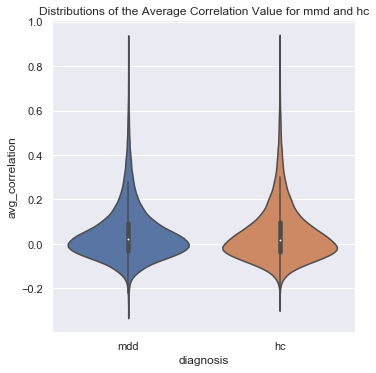

In [111]:
sns.catplot(x='diagnosis', y='avg_correlation', kind='violin', data=df_corrs_avg)
plt.title('Distributions of the Average Correlation Value for mmd and hc')
plt.show()

In [113]:
corr_groups_sex = df_corrs.groupby(by=['diag', 'sex']).mean()
corr_groups_sex = corr_groups_sex.iloc[:, 0:70876].reset_index()
corr_groups_sex = corr_groups_sex.melt(id_vars=['diag', 'sex'],  var_name='corr_idx', value_name='corr_vals')

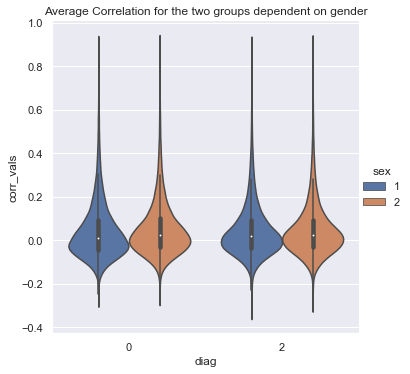

In [114]:
sns.catplot(x='diag', y=corr_groups_sex['corr_vals'], hue='sex', kind='violin', data=corr_groups_sex)
plt.title('Average Correlation for the two groups dependent on gender')
plt.show()

In [115]:
corr_groups_site = df_corrs.groupby(by=['diag', 'site']).mean()
corr_groups_site = corr_groups_site.iloc[:, 0:70876].reset_index()
corr_groups_site = corr_groups_site.melt(id_vars=['diag', 'site'],  var_name='corr_idx', value_name='corr_vals')

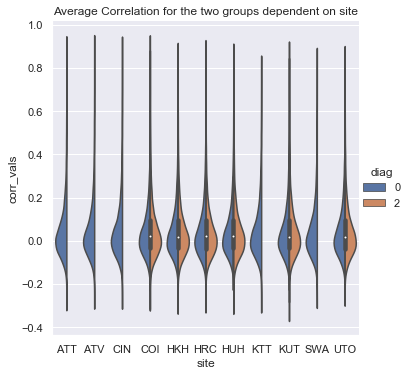

In [116]:
sns.catplot(x='site', y=corr_groups_sex['corr_vals'], hue='diag', kind='violin', split=True, data=corr_groups_site)
plt.title('Average Correlation for the two groups dependent on site')
plt.show()

## A_mats

In [44]:
# average correlations
controls_mats_avg_2d = controls_mats_avg.flatten()
patients_mats_avg_2d = patients_mats_avg.flatten()

df_controls_mats_avg = pd.DataFrame({'avg_connectivity': controls_mats_avg_2d, 'diagnosis': 'hc'})
df_patients_mats_avg = pd.DataFrame({'avg_connectivity': patients_mats_avg_2d, 'diagnosis': 'mdd'})
df_mats_avg = df_patients_mats_avg.append(df_controls_mats_avg)

,avg_connectivity,diagnosis
0,-0.499937,mdd
1,0.000616,mdd
2,0.001699,mdd
3,0.002615,mdd
4,0.001818,mdd
...,...,...
142124,0.001613,hc
142125,0.002342,hc
142126,0.001246,hc
142127,0.000367,hc


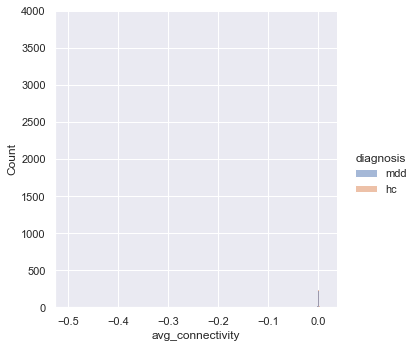

In [45]:
sns.displot(data=df_mats_avg, x='avg_connectivity', hue='diagnosis')

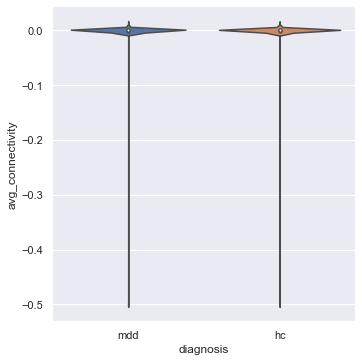

In [46]:
sns.catplot(x='diagnosis', y='avg_connectivity', kind='violin', data=df_mats_avg) 

### scale data across subjects 

In [47]:
def max_min_data(data):
    data_transformed = (data - np.min(data, 0)) / (np.max(data, 0) - np.min(data, 0))
    return data_transformed

def standardise_data(data):
    data_standardised = (data - np.mean(data, 0)) / np.std(data, 0)
    return data_standardised

In [48]:
all_mats_3d_mm = max_min_data(all_mats)
all_mats_2d_mm = max_min_data(all_mats.reshape(all_mats.shape[0], all_mats.shape[1]*all_mats.shape[1]))

all_mats_3d_z = standardise_data(all_mats)
all_mats_2d_z = standardise_data(all_mats.reshape(all_mats.shape[0], all_mats.shape[1]*all_mats.shape[1]))

In [49]:
all_mats_2d_mm.shape

(994, 142129)

In [50]:
mats_mm_df = pd.DataFrame(data = all_mats_2d_mm)
participants.reset_index(drop=True, inplace=True)
df_mats_mm = pd.concat([mats_mm_df, participants], axis=1)

mats_z_df = pd.DataFrame(data = all_mats_2d_z)
df_mats_z = pd.concat([mats_z_df, participants], axis=1)
df_mats_z.shape

(994, 142139)

### Scaled data 

In [51]:
mats_z_groups_diag = df_mats_z.groupby(by=['diag']).mean()
mats_z_groups_diag = mats_z_groups_diag.iloc[:, 0:142129].reset_index()
mats_z_groups_diag = mats_z_groups_diag.melt(id_vars=['diag'],  var_name='mats_idx', value_name='mats_vals')

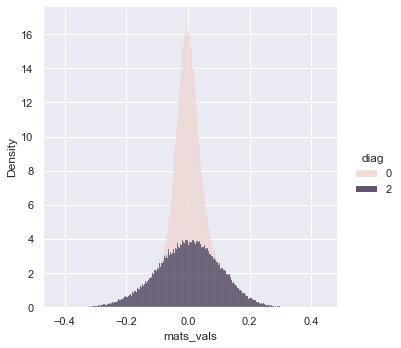

In [52]:
sns.displot(data=mats_z_groups_diag, x='mats_vals', hue='diag', multiple='stack', stat='density', common_norm=False)

In [53]:
mats_mm_groups_diag = df_mats_mm.groupby(by=['diag']).mean()
mats_mm_groups_diag = mats_mm_groups_diag.iloc[:, 0:142129].reset_index()
mats_mm_groups_diag = mats_mm_groups_diag.melt(id_vars=['diag'],  var_name='mats_idx', value_name='mats_vals')

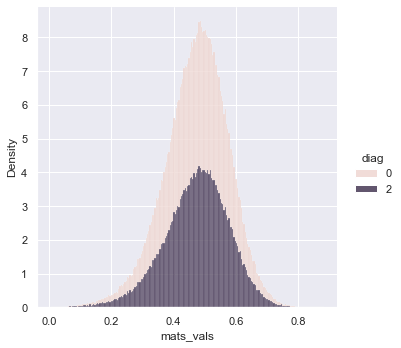

In [54]:
sns.displot(data=mats_mm_groups_diag, x='mats_vals', hue='diag', multiple='stack', stat='density', common_norm=False)

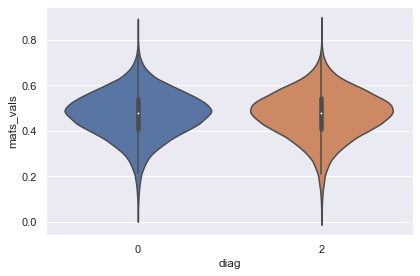

In [55]:
sns.violinplot(x='diag', y='mats_vals', kind='violin', data=mats_mm_groups_diag)
plt.tight_layout()
plt.show()

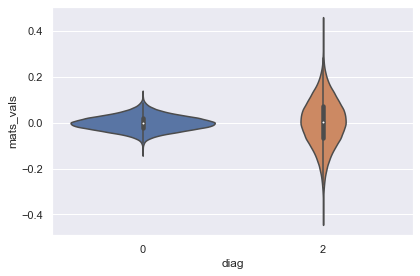

In [56]:
sns.violinplot(x='diag', y='mats_vals', kind='violin', data=mats_z_groups_diag)
plt.tight_layout()
plt.show()

In [57]:
mats_z_groups_sex = df_mats_z.groupby(by=['diag', 'sex']).mean()
mats_z_groups_sex = mats_z_groups_sex.iloc[:, 0:142129].reset_index()
mats_z_groups_sex = mats_z_groups_sex.melt(id_vars=['diag', 'sex'],  var_name='mats_idx', value_name='mats_vals')

mats_mm_groups_sex = df_mats_mm.groupby(by=['diag', 'sex']).mean()
mats_mm_groups_sex = mats_mm_groups_sex.iloc[:, 0:142129].reset_index()
mats_mm_groups_sex = mats_mm_groups_sex.melt(id_vars=['diag', 'sex'],  var_name='mats_idx', value_name='mats_vals')

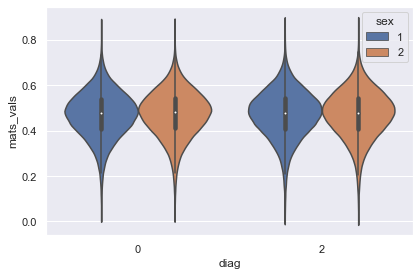

In [58]:
sns.violinplot(x='diag', y='mats_vals', hue='sex', kind='violin', data=mats_mm_groups_sex)
plt.tight_layout()
plt.show()

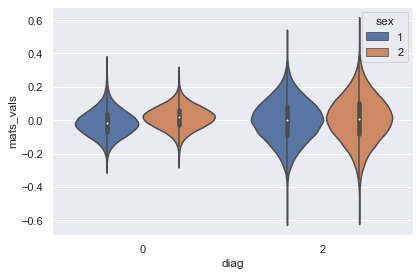

In [59]:
sns.violinplot(x='diag', y='mats_vals', hue='sex', kind='violin', data=mats_z_groups_sex)
plt.tight_layout()
plt.show()

In [60]:
mats_z_groups_site = df_mats_z.groupby(by=['diag', 'site']).mean()
mats_z_groups_site = mats_z_groups_site.iloc[:, 0:142129].reset_index()
mats_z_groups_site = mats_z_groups_site.melt(id_vars=['diag', 'site'],  var_name='mats_idx', value_name='mats_vals')

mats_mm_groups_site = df_mats_mm.groupby(by=['diag', 'site']).mean()
mats_mm_groups_site = mats_mm_groups_site.iloc[:, 0:142129].reset_index()
mats_mm_groups_site = mats_mm_groups_site.melt(id_vars=['diag', 'site'],  var_name='mats_idx', value_name='mats_vals')

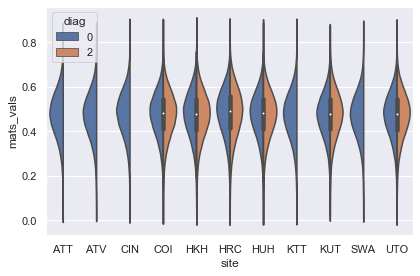

In [61]:
sns.violinplot(x='site', y='mats_vals', hue='diag', kind='violin', split=True, data=mats_mm_groups_site)
plt.tight_layout()
plt.show()

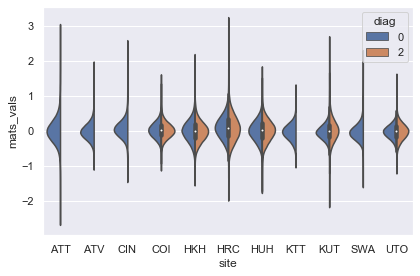

In [62]:
sns.violinplot(x='site', y='mats_vals', hue='diag', kind='violin', split=True, data=mats_z_groups_site)
plt.tight_layout()
plt.show()

### Plot average connectivity of scaled data 

In [64]:
# separate two groups # TODO labels 
controls_mats_mm = all_mats_3d_mm[labels_3d == 0]
patients_mats_mm = all_mats_3d_mm[labels_3d == 2]

controls_mats_z = all_mats_3d_z[labels_3d == 0]
patients_mats_z = all_mats_3d_z[labels_3d == 2]

# average across subjects 
controls_mats_avg_mm = np.mean(controls_mats_mm, 0)
patients_mats_avg_mm = np.mean(patients_mats_mm, 0)

# average across subjects 
controls_mats_avg_z = np.mean(controls_mats_z, 0)
patients_mats_avg_z = np.mean(controls_mats_z, 0)

In [65]:
all_mats_3d_mm.shape

(994, 377, 377)

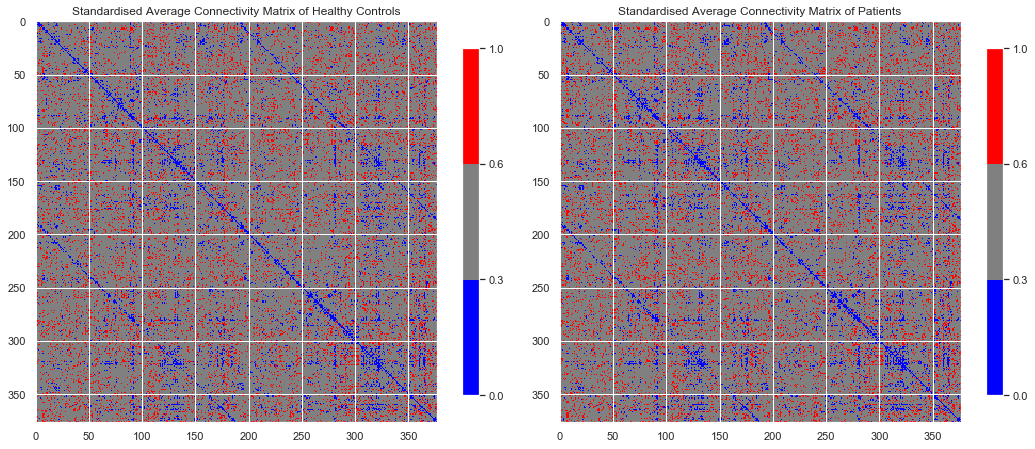

In [66]:
# make a color map of fixed colors
cmap = colors.ListedColormap(['blue', 'gray', 'red'])
bounds_c = [0, 0.3, 0.6, 1]
bounds_p = [0, 0.3, 0.6, 1]
norm_c = colors.BoundaryNorm(bounds_c, cmap.N)
norm_p = colors.BoundaryNorm(bounds_p, cmap.N)

fig, ax = plt.subplots(1, 2, figsize=(15, 10))

ax[0].set_title('Standardised Average Connectivity Matrix of Healthy Controls')
img1 = ax[0].imshow(reorder_regions(controls_mats_avg_mm), interpolation='nearest', cmap=cmap, norm=norm_c)
fig.colorbar(img1, ax=ax[0], cmap=cmap, norm=norm_c, boundaries=bounds_c, ticks=bounds_c, shrink=0.5)


ax[1].set_title('Standardised Average Connectivity Matrix of Patients')
img2 = ax[1].imshow(reorder_regions(patients_mats_avg_mm), interpolation='nearest', cmap=cmap, norm=norm_p)
fig.colorbar(img2, ax=ax[1], cmap=cmap, norm=norm_p, boundaries=bounds_p, ticks=bounds_p, shrink=0.5)

plt.tight_layout()
plt.show() 

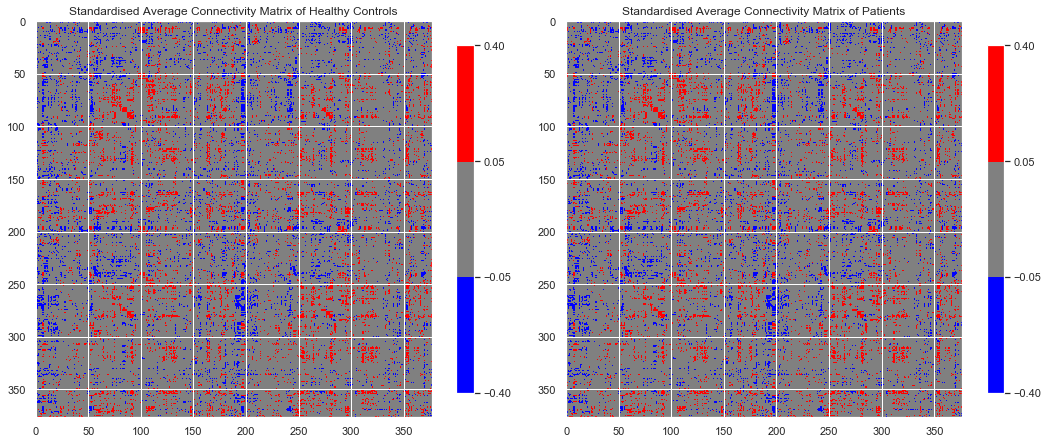

In [67]:
# make a color map of fixed colors
cmap = colors.ListedColormap(['blue', 'gray', 'red'])
bounds_c = [-0.4, -0.05, 0.05, 0.4]
bounds_p = [-0.4, -0.05, 0.05, 0.4]
norm_c = colors.BoundaryNorm(bounds_c, cmap.N)
norm_p = colors.BoundaryNorm(bounds_p, cmap.N)

fig, ax = plt.subplots(1, 2, figsize=(15, 10))

ax[0].set_title('Standardised Average Connectivity Matrix of Healthy Controls')
img1 = ax[0].imshow(reorder_regions(controls_mats_avg_z), interpolation='nearest', cmap=cmap, norm=norm_c)
fig.colorbar(img1, ax=ax[0], cmap=cmap, norm=norm_c, boundaries=bounds_c, ticks=bounds_c, shrink=0.5)


ax[1].set_title('Standardised Average Connectivity Matrix of Patients')
img2 = ax[1].imshow(reorder_regions(controls_mats_avg_z), interpolation='nearest', cmap=cmap, norm=norm_p)
fig.colorbar(img2, ax=ax[1], cmap=cmap, norm=norm_p, boundaries=bounds_p, ticks=bounds_p, shrink=0.5)

plt.tight_layout()
plt.show() 

<br/><br/><br/><br/>

# mass univariate approach 

### t-test, ANCOVA + multiple comparison correction

### t-test with multiple comparison correction correction

In [68]:
def multiple_comp_ttest(group1, group2, alpha, method):
    # compute uncorrected pvalue 
    statss, pvals = stats.ttest_ind(group1, group2)
    n_pvals_uncor = np.sum(pvals <= alpha)
    
    # multiple comparison correction 
    analysis = multitest.multipletests(pvals, alpha, method, is_sorted=False)
    n_pvals_cor = np.sum(analysis[0])
    pvals_cor = analysis[1]
    pvals_mask_cor = analysis[0]
    
    return n_pvals_uncor, n_pvals_cor, pvals_cor, pvals_mask_cor

In [69]:
controls_mats = all_mats[labels_3d == 0]
controls_mats_2d = controls_mats.reshape(controls_mats.shape[0], controls_mats.shape[1]*controls_mats.shape[1])

patients_mats = all_mats[labels_3d == 2]
patients_mats_2d = patients_mats.reshape(patients_mats.shape[0], patients_mats.shape[1]*patients_mats.shape[1])

In [71]:
n_uncor_b_a1_mats, n_cor_b_a1_mats, pvals_b_a1_mats, idx_mask_b_a1_mats = multiple_comp_ttest(controls_mats_2d, patients_mats_2d, 0.05, 'bonferroni')
n_uncor_f_a1_mats, n_cor_f_a1_mats, pvals_f_a1_mats, idx_mask_f_a1_mats = multiple_comp_ttest(controls_mats_2d, patients_mats_2d, 0.05, 'fdr_bh')
n_uncor_b_a2_mats, n_cor_b_a2_mats, pvals_b_a2_mats, idx_mask_b_a1_mats = multiple_comp_ttest(controls_mats_2d, patients_mats_2d, 0.001, 'bonferroni')
n_uncor_f_a2_mats, n_cor_f_a2_mats, pvals_f_a2_mats, idx_mask_f_a1_mats = multiple_comp_ttest(controls_mats_2d, patients_mats_2d, 0.001, 'fdr_bh')

print('A_mats + alpha = 0.05')
print('bonferroni')
print('Number of pvals uncorrected: ', n_uncor_b_a1_mats)
print('Number of pvals corrected:   ', n_cor_b_a1_mats)
print('fdr_bh')
print('Number of pvals uncorrected: ', n_uncor_f_a1_mats)
print('Number of pvals corrected:   ', n_cor_f_a1_mats)
print()
print('A_mats + alpha = 0.001')
print('bonferroni')
print('Number of pvals uncorrected: ', n_uncor_b_a2_mats)
print('Number of pvals corrected:   ', n_cor_b_a2_mats)
print('fdr_bh')
print('Number of pvals uncorrected: ', n_uncor_f_a2_mats)
print('Number of pvals corrected:   ', n_cor_f_a2_mats)

A_mats + alpha = 0.05
bonferroni
Number of pvals uncorrected:  39892
Number of pvals corrected:    765
fdr_bh
Number of pvals uncorrected:  39892
Number of pvals corrected:    19535

A_mats + alpha = 0.001
bonferroni
Number of pvals uncorrected:  10191
Number of pvals corrected:    213
fdr_bh
Number of pvals uncorrected:  10191
Number of pvals corrected:    2859


In [74]:
controls_mats_mm_2d = controls_mats_mm.reshape(controls_mats_mm.shape[0], controls_mats_mm.shape[1]*controls_mats_mm.shape[1])
patients_mats_mm_2d = patients_mats_mm.reshape(patients_mats_mm.shape[0], patients_mats_mm.shape[1]*patients_mats_mm.shape[1])

In [75]:
n_uncor_b_a1_mats_mm, n_cor_b_a1_mats_mm, pvals_b_a1_mats_mm, idx_mask_b__a1_mats_mm = multiple_comp_ttest(controls_mats_mm_2d, patients_mats_mm_2d, 0.05, 'bonferroni')
n_uncor_f_a1_mats_mm, n_cor_f_a1_mats_mm, pvals_f_a1_mats_mm, idx_mask_f_a1_mats_mm = multiple_comp_ttest(controls_mats_mm_2d, patients_mats_mm_2d, 0.05, 'fdr_bh')
n_uncor_b_a2_mats_mm, n_cor_b_a2_mats_mm, pvals_b_a2_mats_mm, idx_mask_b_a1_mats_mm = multiple_comp_ttest(controls_mats_mm_2d, patients_mats_mm_2d, 0.001, 'bonferroni')
n_uncor_f_a2_mats_mm, n_cor_f_a2_mats_mm, pvals_f_a2_mats_mm, idx_mask_f_a1_mats_mm = multiple_comp_ttest(controls_mats_mm_2d, patients_mats_mm_2d, 0.001, 'fdr_bh')

print('MinMax A_mats + alpha = 0.05')
print('bonferroni')
print('Number of pvals uncorrected: ', n_uncor_b_a1_mats_mm)
print('Number of pvals corrected:   ', n_cor_b_a1_mats_mm)
print('fdr_bh')
print('Number of pvals uncorrected: ', n_uncor_f_a1_mats_mm)
print('Number of pvals corrected:   ', n_cor_f_a1_mats_mm)
print()
print('MinMax A_mats + alpha = 0.001')
print('bonferroni')
print('Number of pvals uncorrected: ', n_uncor_b_a2_mats_mm)
print('Number of pvals corrected:   ', n_cor_b_a2_mats_mm)
print('fdr_bh')
print('Number of pvals uncorrected: ', n_uncor_f_a2_mats_mm)
print('Number of pvals corrected:   ', n_cor_f_a2_mats_mm)

MinMax A_mats + alpha = 0.05
bonferroni
Number of pvals uncorrected:  39892
Number of pvals corrected:    765
fdr_bh
Number of pvals uncorrected:  39892
Number of pvals corrected:    19535

MinMax A_mats + alpha = 0.001
bonferroni
Number of pvals uncorrected:  10191
Number of pvals corrected:    213
fdr_bh
Number of pvals uncorrected:  10191
Number of pvals corrected:    2859


In [76]:
controls_mats_z_2d = controls_mats_z.reshape(controls_mats_z.shape[0], controls_mats_z.shape[1]*controls_mats_z.shape[1])
patients_mats_z_2d = patients_mats_z.reshape(patients_mats_z.shape[0], patients_mats_z.shape[1]*patients_mats_z.shape[1])

In [77]:
n_uncor_b_a1_mats_z, n_cor_b_a1_mats_z, pvals_b_a1_mats_z, idx_mask_b__a1_mats_z = multiple_comp_ttest(controls_mats_z_2d, patients_mats_z_2d, 0.05, 'bonferroni')
n_uncor_f_a1_mats_z, n_cor_f_a1_mats_z, pvals_f_a1_mats_z, idx_mask_f_a1_mats_z = multiple_comp_ttest(controls_mats_z_2d, patients_mats_z_2d, 0.05, 'fdr_bh')
n_uncor_b_a2_mats_z, n_cor_b_a2_mats_z, pvals_b_a2_mats_z, idx_mask_b_a1_mats_z = multiple_comp_ttest(controls_mats_z_2d, patients_mats_z_2d, 0.001, 'bonferroni')
n_uncor_f_a2_mats_z, n_cor_f_a2_mats_z, pvals_f_a2_mats_z, idx_mask_f_a1_mats_z = multiple_comp_ttest(controls_mats_z_2d, patients_mats_z_2d, 0.001, 'fdr_bh')

print('Z A_mats + alpha = 0.05')
print('bonferroni')
print('Number of pvals uncorrected: ', n_uncor_b_a1_mats_z)
print('Number of pvals corrected:   ', n_cor_b_a1_mats_z)
print('fdr_bh')
print('Number of pvals uncorrected: ', n_uncor_f_a1_mats_z)
print('Number of pvals corrected:   ', n_cor_f_a1_mats_z)
print()
print('Z A_mats + alpha = 0.001')
print('bonferroni')
print('Number of pvals uncorrected: ', n_uncor_b_a2_mats_z)
print('Number of pvals corrected:   ', n_cor_b_a2_mats_z)
print('fdr_bh')
print('Number of pvals uncorrected: ', n_uncor_f_a2_mats_z)
print('Number of pvals corrected:   ', n_cor_f_a2_mats_z)

Z A_mats + alpha = 0.05
bonferroni
Number of pvals uncorrected:  39892
Number of pvals corrected:    765
fdr_bh
Number of pvals uncorrected:  39892
Number of pvals corrected:    19535

Z A_mats + alpha = 0.001
bonferroni
Number of pvals uncorrected:  10191
Number of pvals corrected:    213
fdr_bh
Number of pvals uncorrected:  10191
Number of pvals corrected:    2859


In [78]:
n_uncor_b_a1_cor, n_cor_b_a1_cor, pvals_b_a1_cor, idx_mask_b__a1_cor = multiple_comp_ttest(controls_cors, patients_cors, 0.05, 'bonferroni')
n_uncor_f_a1_cor, n_cor_f_a1_cor, pvals_f_a1_cor, idx_mask_f_a1_cor = multiple_comp_ttest(controls_cors, patients_cors, 0.05, 'fdr_bh')
n_uncor_b_a2_cor, n_cor_b_a2_cor, pvals_b_a2_cor, idx_mask_b_a1_cor = multiple_comp_ttest(controls_cors, patients_cors, 0.001, 'bonferroni')
n_uncor_f_a2_cor, n_cor_f_a2_cor, pvals_f_a2_cor, idx_mask_f_a1_cor = multiple_comp_ttest(controls_cors, patients_cors, 0.001, 'fdr_bh')

print('Corrs + alpha = 0.05')
print('bonferroni')
print('Number of pvals uncorrected: ', n_uncor_b_a1_cor)
print('Number of pvals corrected:   ', n_cor_b_a1_cor)
print('fdr_bh')
print('Number of pvals uncorrected: ', n_uncor_f_a1_cor)
print('Number of pvals corrected:   ', n_cor_f_a1_cor)
print()
print('Corrs + alpha = 0.001')
print('bonferroni')
print('Number of pvals uncorrected: ', n_uncor_b_a2_cor)
print('Number of pvals corrected:   ', n_cor_b_a2_cor)
print('fdr_bh')
print('Number of pvals uncorrected: ', n_uncor_f_a2_cor)
print('Number of pvals corrected:   ', n_cor_f_a2_cor)

Corrs + alpha = 0.05
bonferroni
Number of pvals uncorrected:  26204
Number of pvals corrected:    1448
fdr_bh
Number of pvals uncorrected:  26204
Number of pvals corrected:    17781

Corrs + alpha = 0.001
bonferroni
Number of pvals uncorrected:  9047
Number of pvals corrected:    553
fdr_bh
Number of pvals uncorrected:  9047
Number of pvals corrected:    4397


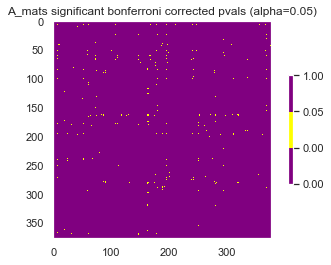

In [82]:
cmap = colors.ListedColormap(['purple', 'yellow', 'purple'])
bounds= [0,0.000001,0.05, 1]
norm = colors.BoundaryNorm(bounds, cmap.N)
n_cor_b_a1_mats.shape
img = plt.imshow(reorder_regions(pvals_b_a1_mats.reshape(377, 377)), interpolation='nearest', cmap=cmap, norm=norm)
plt.colorbar(img, cmap=cmap, norm=norm, boundaries=bounds, ticks=bounds, shrink=0.5)
plt.title('A_mats significant bonferroni corrected pvals (alpha=0.05)')
plt.grid(False)
plt.show()

In [86]:
# read in area labels 
df_brainReg = pd.read_csv('../Parcellation/labels.txt', sep=' ', header=None)
names_br = np.array(df_brainReg[1])
names_br.shape

(377,)

In [137]:
sig_rows_mats = np.sum(reorder_regions(idx_mask_b_a1_mats.reshape(377, 377)), 0)
sig_cols_mats = np.sum(reorder_regions(idx_mask_b_a1_mats.reshape(377, 377)), 1)

sig_regions_mats = pd.DataFrame(np.array([sig_rows_mats, sig_cols_mats]).T, columns=['rows', 'cols'], index=[names_br])
mats_max = sig_regions_mats.nlargest(25, 'rows')
mats_sig = set(mats_max.index.to_numpy())

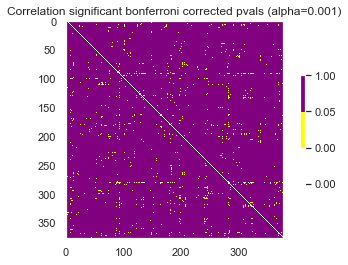

In [88]:
cmap = colors.ListedColormap(['white', 'yellow', 'purple'])
bounds= [0,0.000001,0.05, 1]
norm = colors.BoundaryNorm(bounds, cmap.N)

img = plt.imshow(reorder_regions(mirrow_triangle(flatt2mat(pvals_b_a2_cor, 377))), interpolation='nearest', cmap=cmap, norm=norm)
plt.colorbar(img, cmap=cmap, norm=norm, boundaries=bounds, ticks=bounds, shrink=0.5)
plt.title('Correlation significant bonferroni corrected pvals (alpha=0.001)')
plt.grid(False)
plt.show()

In [134]:
sig_rows = np.sum(reorder_regions(mirrow_triangle(flatt2mat(idx_mask_b_a1_cor, 377))), 0)
sig_cols = np.sum(reorder_regions(mirrow_triangle(flatt2mat(idx_mask_b_a1_cor, 377))), 1)

sig_regions = pd.DataFrame(np.array([sig_rows, sig_cols]).T, columns=['rows', 'cols'], index=[names_br])
cors_max = sig_regions.nlargest(25, 'rows')
cors_sig = set(cors_max.index.to_numpy())

In [138]:
mats_sig.intersection(cors_sig)

{('L_3b_ROI',),
 ('L_4_ROI',),
 ('L_a24pr_ROI',),
 ('L_p24_ROI',),
 ('R_8Ad_ROI',),
 ('R_FFC_ROI',),
 ('R_IPS1_ROI',),
 ('Right-Thalamus',)}

In [140]:
# MAAAAAYBE TODO???

all_cor_reg = set(sig_regions.index.to_numpy())
all_mat_reg = set(sig_regions_mats.index.to_numpy())
len(all_cor_reg.intersection(all_mat_reg))

377

### ANCOVA single region all subjects 

#### A_mats

In [233]:
anova_outs = pd.DataFrame()

df_y = pd.DataFrame({'con': df_mats_stand[0]})
df_x = df_mats_stand[['site_num', 'age_cat', 'sex', 'diag']]
df_x.reset_index(drop=True, inplace=True)
df_anova = pd.concat([df_y, df_x], axis=1)
df_anova = df_anova.dropna()

aov = ancova(data=df_anova, dv='con', between='diag', covar=['sex', 'age_cat', 'site_num'])
a = anova_outs.append(aov)
a['con'] = 1
a

,Source,SS,DF,F,p-unc,np2,con
0,diag,0.226639,1,10.856684,0.001018,0.010351,1
1,sex,0.151150,1,7.240530,0.007242,0.006927,1
2,age_cat,0.002552,1,0.122257,0.726670,0.000118,1
3,site_num,0.203244,1,9.735997,0.001857,0.009292,1
4,Residual,21.668825,1038,NaN,NaN,NaN,1


In [141]:
anova_pvals = pd.DataFrame(columns=['diag', 'sex', 'age_cat', 'site_num'])
anova_pvals.append(a['p-unc'][:4])
anova_pvals

,diag,sex,age_cat,site_num


In [234]:
df_x = df_mats_stand[['site_num', 'age_cat', 'sex', 'diag']]
df_x.reset_index(drop=True, inplace=True)

anova_outs = pd.DataFrame()

for idx in tqdm.tqdm(range(377*377)):
    df_y = pd.DataFrame({'con': df_mats_stand[idx]})
    df_anova = pd.concat([df_y, df_x], axis=1)
    df_anova = df_anova.dropna()
    
    aov = ancova(data = df_anova, dv = 'con', between = 'diag', covar = ['sex', 'age_cat', 'site_num'])
    
    anova_outs = anova_outs.append(aov)
    anova_outs['con'] = idx

anova_outs

100%|████████████████████████████████████████████████████████████████████████| 142129/142129 [3:39:11<00:00, 10.81it/s]


,Source,SS,DF,F,p-unc,np2,con
0,diag,0.226639,1,10.856684,0.001018,0.010351,142128
1,sex,0.151150,1,7.240530,0.007242,0.006927,142128
2,age_cat,0.002552,1,0.122257,0.726670,0.000118,142128
3,site_num,0.203244,1,9.735997,0.001857,0.009292,142128
4,Residual,21.668825,1038,NaN,NaN,NaN,142128
...,...,...,...,...,...,...,...
0,diag,0.087323,1,3.810975,0.051186,0.003658,142128
1,sex,0.162779,1,7.104069,0.007810,0.006797,142128
2,age_cat,0.012478,1,0.544585,0.460706,0.000524,142128
3,site_num,0.244650,1,10.677119,0.001120,0.010182,142128


In [498]:
anova_outs.to_csv('ancova_outs.csv')

In [340]:
pvals_sites = anova_outs[anova_outs['Source'] == 'site_num']['p-unc']
pvals_sex = anova_outs[anova_outs['Source'] == 'sex']['p-unc']
pvals_diag = np.array(anova_outs[anova_outs['Source'] == 'diag']['p-unc'])
pvals_agecat = anova_outs[anova_outs['Source'] == 'age_cat']['p-unc']

In [347]:
len(pvals_diag)

142129

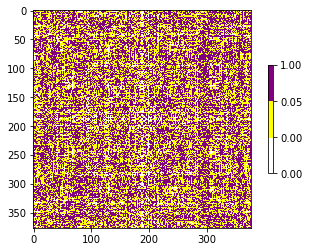

In [354]:
cmap = colors.ListedColormap(['white', 'yellow', 'purple'])
bounds= [0,0.000001,0.05, 1]
norm = colors.BoundaryNorm(bounds, cmap.N)

img = plt.imshow(pvals_diag.reshape(377, 377), interpolation='nearest', cmap=cmap, norm=norm)
plt.colorbar(img, cmap=cmap, norm=norm, boundaries=bounds, ticks=bounds, shrink=0.5)

<br/><br/><br/><br/>

# multivariate approach 

### PCA, (LPCA), ICA

In [74]:
all_mats_z = (all_mats - np.min(all_mats, 0)) / (np.max(all_mats, 0) - np.min(all_mats, 0))

In [75]:
controls_z = (controls_2d - np.min(controls_2d, 0)) / (np.max(controls_2d, 0) - np.min(controls_2d, 0))
patients_z = (patients_2d - np.min(patients_2d, 0)) / (np.max(patients_2d, 0) - np.min(patients_2d, 0))

In [100]:
pca_c= PCA()
pca_c.fit(controls_z.T)
components_c = pca_c.components_
components_c.shape
ratio_c = pca_c.explained_variance_ratio_
ratio_c.shape

(791,)

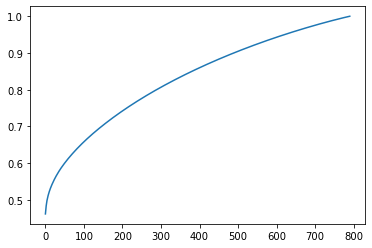

In [119]:
plt.plot(np.cumsum(ratio_c))
plt.show()

In [120]:
pca_p = PCA()
pca_p.fit(patients_z.T)
components_p = pca_p.components_
components_p.shape
ratio_p = pca_p.explained_variance_ratio_
ratio_p.shape

(252,)

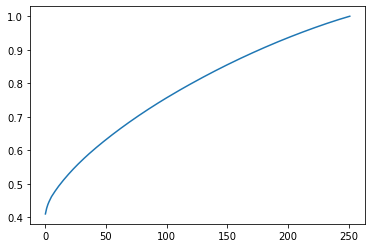

In [121]:
plt.plot(np.cumsum(ratio_p))
plt.show()

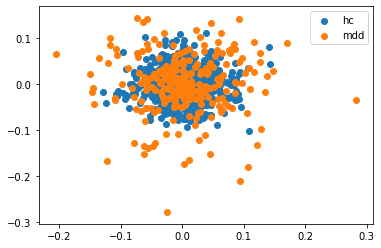

In [127]:
plt.scatter(components_c[:, 0],components_c[:, 1], label='hc')
plt.scatter(components_p[:, 0],components_p[:, 1], label='mdd')
plt.legend()
plt.show()

In [107]:
pca = PCA()
pca.fit(all_mats_z.reshape(all_mats_z.shape[0], all_mats_z.shape[1]*all_mats_z.shape[1]).T)
components = pca.components_
components.shape

(1043, 1043)

In [110]:
ratio = pca.explained_variance_ratio_
ratio.shape

(1043,)

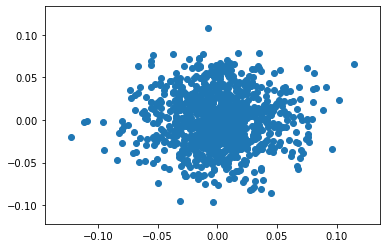

In [109]:
plt.scatter(components[:, 0],components[:, 1])
plt.show()

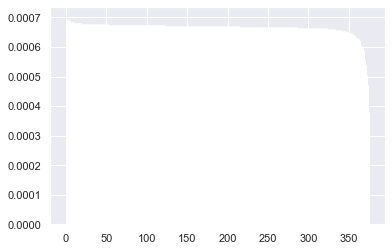

In [163]:
exp_var = pca.explained_variance_
plt.bar(x=np.arange(0, len(exp_var)), height=exp_var)
plt.show()

# k-means on mdd-patients A-mats

In [84]:
# 252 x 377*377 - find pattern that is consitent across subjects 
patients_z.shape

(252, 142129)

(0, 500)

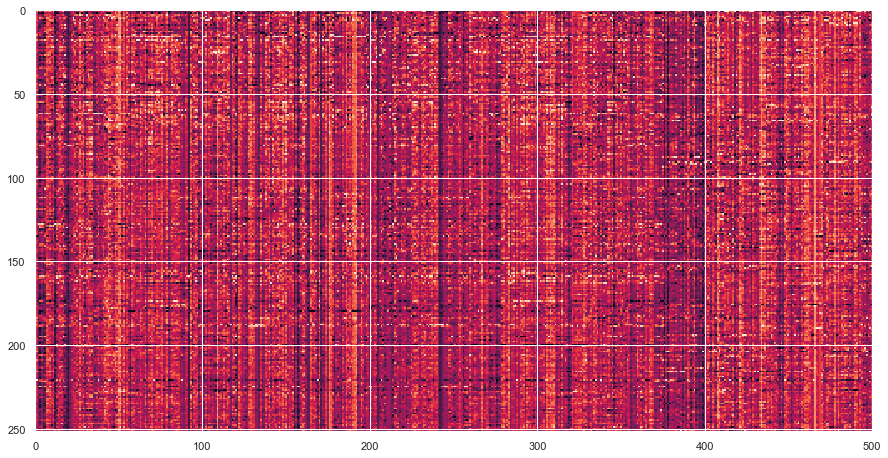

In [85]:
plt.figure(figsize=(15, 10))
plt.imshow(patients_z)
plt.xlim(0, 500)

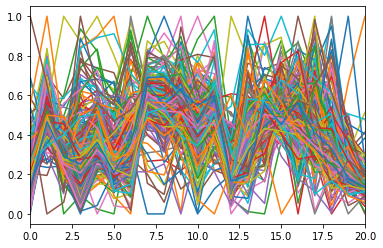

In [422]:
for idx in range(252):
    plt.plot(np.arange(len(patients_z[0, :])), patients_z[idx, :])
    plt.xlim(0, 20)
plt.show()

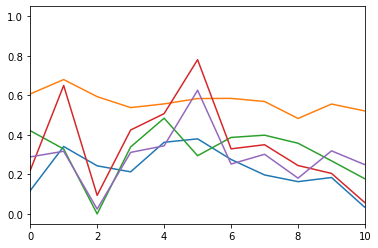

In [449]:
for idx in range(5):
    plt.plot(np.arange(len(patients_z[:, idx].T)), patients_z[:, idx].T)
    plt.xlim(0,10)
plt.show()


## Find optimal k

In [90]:
# function returns WSS score for k values from 1 to kmax
def calculate_WSS(data, kmax):
    sse = []
    for k in tqdm.tqdm(range(1, kmax+1)):
        kmeans = KMeans(n_clusters = k).fit(data)
        centroids = kmeans.cluster_centers_
        pred_clusters = kmeans.predict(data)
        curr_sse = 0
    
        # calculate square of Euclidean distance of each point from its cluster center and add to current WSS
        for i in tqdm.tqdm(range(len(data))):
            curr_center = centroids[pred_clusters[i]]
            curr_sse += (data[i, 0] - curr_center[0]) ** 2 + (data[i, 1] - curr_center[1]) ** 2
        
        sse.append(curr_sse)
    
    return sse

In [91]:
patients_mats.shape

(252, 377, 377)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [04:30<00:00, 27.07s/it]


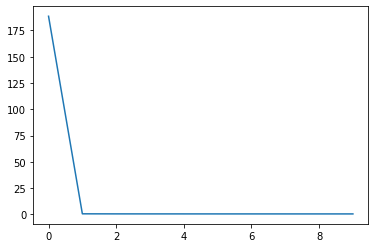

In [92]:
# a_mats 
patients_mats_2d = patients_mats.reshape(patients_mats.shape[0], patients_mats.shape[1]*patients_mats.shape[1])
kopt_mats = calculate_WSS(patients_mats_2d.T, 10)
plt.plot(kopt_mats)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [08:21<00:00, 50.14s/it]


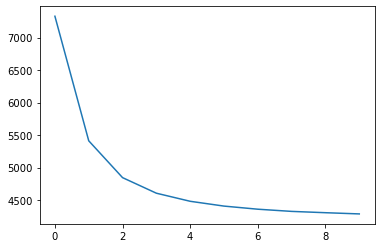

In [95]:
# MinMax a_mats 
patients_mats_mm_2d = patients_mats_mm.reshape(patients_mats_mm.shape[0], patients_mats_mm.shape[1]*patients_mats_mm.shape[1])
kopt_mats_mm = calculate_WSS(patients_mats_mm_2d.T, 10)
plt.plot(kopt_mats_mm)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [11:26<00:00, 68.63s/it]


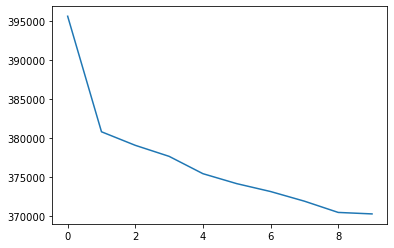

In [96]:
# z a_mats
patients_mats_z_2d = patients_mats_z.reshape(patients_mats_z.shape[0], patients_mats_z.shape[1]*patients_mats_z.shape[1])
kopt_mats_z = calculate_WSS(patients_mats_z_2d.T, 10)
plt.plot(kopt_mats_z)

In [97]:
patients_cors.shape

(252, 70876)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:53<00:00, 23.37s/it]


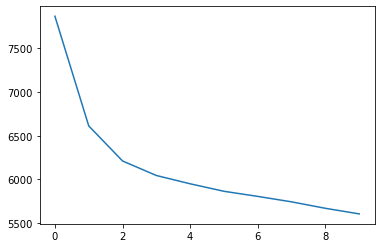

In [98]:
# Corrs 
kopt_mats = calculate_WSS(patients_cors.T, 10)
plt.plot(kopt_mats)

In [138]:
sil = []
kmax = 10

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in tqdm.tqdm(range(2, kmax+1)):
    kmeans = KMeans(n_clusters = k).fit(patients_z.T)
    labels = kmeans.labels_
    sil.append(silhouette_score(patients_z.T, labels, metric = 'euclidean'))

100%|█████████████████████████████████████████████████████████████████████████████████| 9/9 [1:25:24<00:00, 569.41s/it]


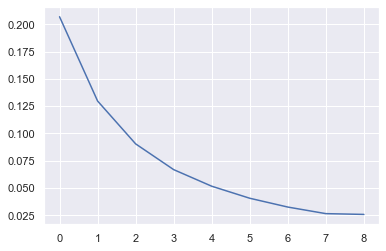

In [141]:
plt.plot(sil)

<br/><br/>

### test optimal k 

In [100]:
k = 4
kmeans = KMeans(n_clusters=k, random_state=8).fit_transform(patients_mats_z_2d.T)
kmeans.shape

(142129, 4)

In [ ]:
plt.figure(figsize=(15,10)) 

for idx in range(k):
    plt.plot(np.arange(len(patients_mats_z_2d)), patients_mats_z_2d, alpha=0.1)
    plt.plot(np.arange(len(kmeans[:, idx].T)), kmeans[:, idx].T)
plt.xlim(0, 10)
plt.show()